In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

sn.set_context('notebook')

# Estimating loads in unmonitored regions

The output from the new model can be used to estimate loads in unmonitored areas. We know the regine ID for each of the 155 stations where water chemistry is measured, and we also know which OSPAR region each monitoring site drains to. We want to use observed data to estimate loads upstream of each monitoring point, and modelled data elsewhere. This can easily be achieved using the output from the new model.

**Note:** In the analysis below, I'm **assuming that none of the 155 sites are upstream of one another**. I think this is correct (despite some of the sites being referred to as "tributaries" on some occasions), but need to check as it could substantially affect the results.

**Note 2:** In the code below, I'm assuming that we want to use the observed data for all 155 sites. In reality, values for the `RID_108` stations are estimated using linear interpolation, so we may prefer to use the modelled output for these anyway. Furthermore, in the OSPAR template we only report observed values for the 11 main rivers. The choice of which sites to consider "observed" can easily be controlled by reading different sheet(s) into `stn_df` in the code below.

In [2]:
# Read model output
in_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
          r'\NOPE\nope_results_2015.csv')
nope_df = pd.read_csv(in_csv)

# Read station data
in_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\Data\RID_Sites_List.xlsx')
stn_df = pd.read_excel(in_xlsx, sheetname='RID_All')

# Join accumulated outputs to stns
mon_df = pd.merge(stn_df, nope_df, how='left',
                  left_on='nve_vassdrag_nr',
                  right_on='regine')

# Groupby OSPAR region
mon_df = mon_df.groupby('ospar_region').sum()

# Get just accum cols
cols = [i for i in mon_df.columns if i.split('_')[0]=='accum']
mon_df = mon_df[cols]

mon_df.head()

,accum_all_point_n_tonnes,accum_all_point_p_tonnes,accum_all_sources_n_tonnes,accum_all_sources_p_tonnes,accum_anth_diff_n_tonnes,accum_anth_diff_p_tonnes,accum_aqu_n_tonnes,accum_aqu_p_tonnes,accum_ind_n_tonnes,accum_ind_p_tonnes,accum_nat_diff_n_tonnes,accum_nat_diff_p_tonnes,accum_q_m3/s,accum_ren_n_tonnes,accum_ren_p_tonnes,accum_spr_n_tonnes,accum_spr_p_tonnes,accum_upstr_area_km2
ospar_region,,,,,,,,,,,,,,,,,,
LOFOTEN-BARENTS SEA,87.191590,6.121411,4369.203002,63.671394,139.942168,5.257377,0.0,0.0,0.000000,0.000000,4142.069244,52.292606,894.898861,33.467862,1.197379,50.645588,4.659198,63555.61
NORTH SEA,429.457219,39.312303,16304.888225,225.018315,2653.125671,71.007893,0.0,0.0,10.364882,0.208263,13222.305335,114.698118,2186.417874,214.917480,23.786032,138.223766,11.192731,25223.53
NORWEGIAN SEA2,624.624604,45.615322,14648.734767,277.988553,2934.138192,80.659255,0.0,0.0,10.296000,1.352000,11089.971971,151.713976,2126.919172,339.803064,19.026916,204.447297,20.119235,49150.49
SKAGERAK,3851.069223,101.283736,33158.161544,494.536159,11045.877626,239.188995,0.0,0.0,47.510520,2.170000,18261.214695,154.063428,2565.802776,2618.737981,25.268397,861.069646,52.089139,94172.25


This table gives the **modelled** inputs to each OSPAR region from catchments for which we have observed data. We want to subtract these values from the overall modelled inputs to each region and substitute the observed data instead.

The trickiest part of this is that the OSPAR regions in the TEOTIL catchment network (and therefore the network for my new model too) don't exactly match the new OSPAR definitions. The OSPAR boundaries were updated relatively recently, so instead of simply selecting the desired OSPAR region in the model output, I need to aggregate based on vassdragsnummers.

In [3]:
# Define "new" OSPAR regions
os_dict = {'SKAGERAK':(1, 23),
           'NORTH SEA':(24, 90),
           'NORWEGIAN SEA2':(91, 170),
           'LOFOTEN-BARENTS SEA':(171, 247)}

# Container for results
df_list = []

# Loop over model output
for reg in os_dict.keys():
    min_id, max_id = os_dict[reg]
    
    regs = ['%03d.' % i for i in range(min_id, max_id+1)]
    
    # Get data for this region
    df2 = nope_df[nope_df['regine'].isin(regs)]
    
    # Get just accum cols
    cols = [i for i in df2.columns if i.split('_')[0]=='accum']
    df2 = df2[cols]
    
    # Add region
    df2['ospar_region'] = reg
    
    # Add sum to output
    df_list.append(df2)

# Build df
os_df = pd.concat(df_list, axis=0)

# Aggregate
os_df = os_df.groupby('ospar_region').sum()

os_df.head()

,accum_all_point_n_tonnes,accum_all_point_p_tonnes,accum_all_sources_n_tonnes,accum_all_sources_p_tonnes,accum_anth_diff_n_tonnes,accum_anth_diff_p_tonnes,accum_aqu_n_tonnes,accum_aqu_p_tonnes,accum_ind_n_tonnes,accum_ind_p_tonnes,accum_nat_diff_n_tonnes,accum_nat_diff_p_tonnes,accum_q_m3/s,accum_ren_n_tonnes,accum_ren_p_tonnes,accum_spr_n_tonnes,accum_spr_p_tonnes,accum_upstr_area_km2
ospar_region,,,,,,,,,,,,,,,,,,
LOFOTEN-BARENTS SEA,15439.872162,2606.821398,25551.566477,2779.756587,595.173829,28.966139,14083.369195,2432.643422,58.40000,4.500000,9516.520486,143.969050,2342.607786,980.056211,131.298631,305.310495,37.311038,138090.89
NORTH SEA,24065.212516,3799.269740,56720.734879,4244.832901,6222.324609,192.173586,19268.475618,3323.545977,410.56844,83.353097,26433.197753,253.389576,4410.640159,3552.271820,302.041142,687.427069,79.776433,59314.38
NORWEGIAN SEA2,28563.460501,4688.643425,55880.176466,5212.387870,7348.523085,233.430229,24173.535579,4183.786056,940.26600,88.330000,19968.192880,290.314217,4128.221536,2548.571916,315.031443,743.577132,89.043775,113934.05
SKAGERAK,10498.443197,279.515299,42867.161416,760.324595,12749.251124,312.982552,43.160886,7.551444,1001.31052,35.970000,19619.467095,167.826744,2709.349996,8052.337462,140.836317,1027.241973,69.674160,102574.69


We can now calculate the unmonitored component by simply subtracting the values modelled upstream of monitoring stations from the overall modelled inputs to each OSPAR region.

In [4]:
# Calc unmonitored loads
unmon_df = os_df - mon_df

# Write output
out_csv = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\unmonitored_loads_2015.csv')
unmon_df.to_csv(out_csv, encoding='utf-8', index_label='ospar_region')

unmon_df.T

ospar_region,LOFOTEN-BARENTS SEA,NORTH SEA,NORWEGIAN SEA2,SKAGERAK
accum_all_point_n_tonnes,15352.680572,23635.755297,27938.835896,6647.373974
accum_all_point_p_tonnes,2600.699987,3759.957436,4643.028103,178.231563
accum_all_sources_n_tonnes,21182.363475,40415.846654,41231.441699,9708.999872
accum_all_sources_p_tonnes,2716.085193,4019.814586,4934.399317,265.788436
accum_anth_diff_n_tonnes,455.231661,3569.198939,4414.384893,1703.373498
accum_anth_diff_p_tonnes,23.708762,121.165692,152.770974,73.793557
accum_aqu_n_tonnes,14083.369195,19268.475618,24173.535579,43.160886
accum_aqu_p_tonnes,2432.643422,3323.545977,4183.786056,7.551444
accum_ind_n_tonnes,58.400000,400.203558,929.970000,953.800000
accum_ind_p_tonnes,4.500000,83.144834,86.978000,33.800000


For comparison with the previous methodology, I have extracted the loads from Table 3 of the 2015 report and added them to Excel. I have also aggregated the table above into approximately the same categories used by Tore in the report. The bar charts below illustrate the results obtained from the two methods. **Note the log scale on the y-axis**.

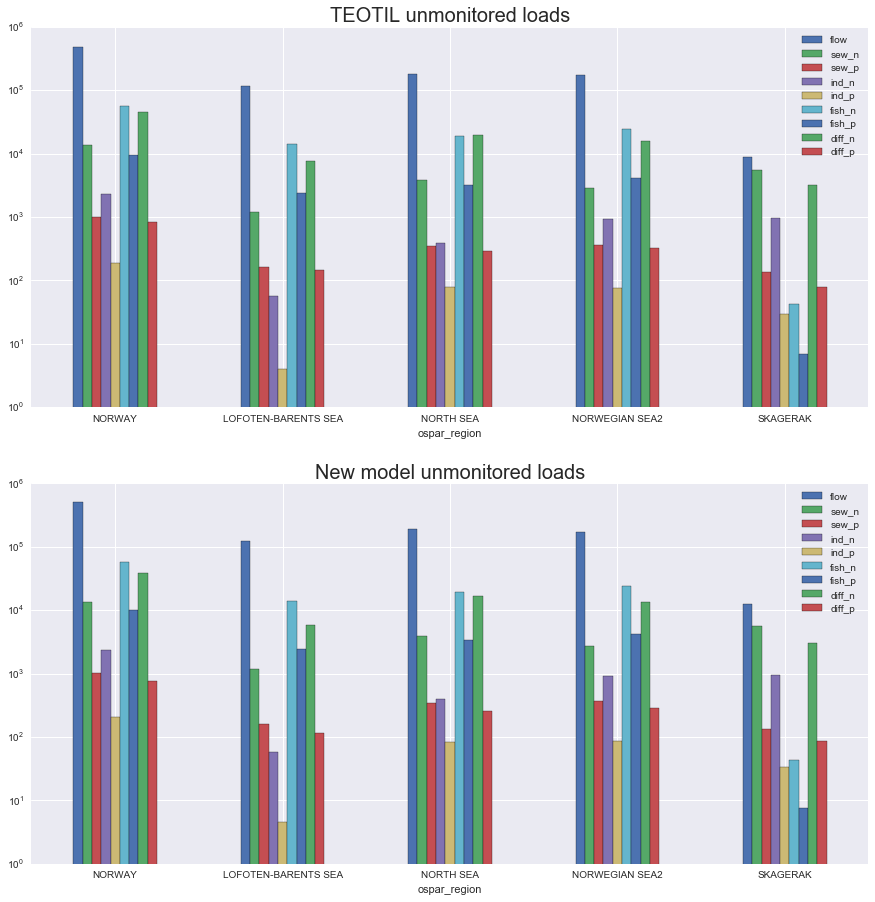

In [5]:
# Read data
in_xlsx = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\unmonitored_loads_2015_nope_vs_report.xlsx')
old_df = pd.read_excel(in_xlsx, sheetname='2015_report', index_col=0)
new_df = pd.read_excel(in_xlsx, sheetname='nope_output', index_col=0)

# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,15))
old_df.plot.bar(ax=axes[0], rot=0, logy=True)
new_df.plot.bar(ax=axes[1], rot=0, logy=True)

# Labels
axes[0].set_title('TEOTIL unmonitored loads', fontsize=20)
axes[1].set_title('New model unmonitored loads', fontsize=20)

plt.show()